# Определение стоимости автомобилей

### Описание проекта

В рамках проекта по развитию сервиса по продаже автомобилей с пробегом «Не бит, не крашен» планируется создание пользовательского приложения, позволяющего быстро и удобно получить оценку рыночной стоимости автомобиля. Такой функционал поможет привлечь новых клиентов, повысить вовлечённость и автоматизировать первичную оценку транспортных средств.

**Цель:**
Наша задача — разработать и внедрить модель машинного обучения, которая будет предсказывать стоимость автомобилей на основе их технических характеристик. Особое внимание необходимо уделить:
- высокому качеству предсказания;
- минимальному времени предсказании;
- оптимальному времени обучения модели.

**Ход решения:**
1. **Загрузка и первичный анализ данных**    
На первом этапе мы загружаем датасет `autos.csv`. Далее проводим обзор данных:
    * формат данных признаков,
    * распределение значений,
    * наличие пропусков.
2. **Очистка и предобработка**    
Заполняем пропущенные значения, устраняем аномалии и проверяем выбросы в числовых признаках. Также исключаем неинформативные или дублирующие столбцы, которые не несут ценности для модели. 
3. **Подготовка выборок**    
Данные делим на обучающую и тестовую выборки. Категориальные признаки кодируем, а числовые могут масштабироваться при необходимости.
4. **Обучение моделей и подбор гиперпараметров**    
Мы обучаем несколько моделей, включая:
    * LightGBM — как эффективный градиентный бустинг;
    * модели без бустинга — например, линейную регрессию и случайный лес.
Для каждой модели подбираем оптимальные гиперпараметры с помощью RandomizedSearch.
5. **Оценка и сравнение моделей**    
Для всех моделей измеряем:
    * качество предсказания по метрике RMSE, где она не превышает 2500,
    * время обучения,
    * время предсказания на новых данных.
6. **Выбор лучшей модели и финальная проверка**    
Опираясь на критерии заказчика (точность, быстрота, обучаемость), выбираем оптимальную модель. Её финальное качество проверяется на тестовой выборке, не участвовавшей в обучении.

**Входные признаки:**   
`DateCrawled` — дата скачивания анкеты из базы    
`VehicleType` — тип автомобильного кузова    
`RegistrationYear` — год регистрации автомобиля    
`Gearbox` — тип коробки передач    
`Power` — мощность (л. с.)    
`Model` — модель автомобиля    
`Kilometer` — пробег (км)    
`RegistrationMonth` — месяц регистрации автомобиля    
`FuelType` — тип топлива    
`Brand` — марка автомобиля    
`Repaired` — была машина в ремонте или нет    
`DateCreated` — дата создания анкеты    
`NumberOfPictures` — количество фотографий автомобиля    
`PostalCode` — почтовый индекс владельца анкеты (пользователя)    
`LastSeen` — дата последней активности пользователя    

**Целевой признак:**    
`Price` — цена (евро)

## Импорт библиотек

In [7]:
!pip install phik -q

In [8]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import lightgbm as lgb

from phik import phik_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform

In [10]:
import warnings

warnings.filterwarnings("ignore")

## Добавление функций

In [12]:
def df_review(df):
    """Выполняет первичный обзор DataFrame: отображает первые строки, информацию о столбцах и описание статистики данных."""
    display(df.head())
    df.info()
    display(df.describe())

In [13]:
def run_search(name, pipeline, param_dist):
    """Выполняет подбор гиперпараметров с помощью RandomizedSearchCV, обучает переданный pipeline на обучающей выборке 
    и возвращает обученный объект поиска вместе с временем, затраченным на обучение."""
    t0 = time.perf_counter()
    search = RandomizedSearchCV(
        pipeline,
        param_dist,
        n_iter=12,
        cv=3,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        scoring="neg_root_mean_squared_error",
        verbose=0,
    )
    search.fit(X_train, y_train)
    return search, time.perf_counter() - t0

In [14]:
def timed_pred(model):
    """Выполняет предсказание на тестовой выборке и измеряет время, затраченное на это."""
    t0 = time.perf_counter(); pred = model.predict(X_test); return pred, time.perf_counter() - t0

In [15]:
def evaluate(name, pred, train_t, pred_t):
    """Оценивает качество модели на тестовой выборке и формирует словарь с результатами."""
    rmse = mean_squared_error(y_test, pred, squared=False)
    return {
        "Model": name,
        "RMSE": rmse,
        "TrainTime_s": train_t,
        "PredictTime_ms": pred_t * 1e3,
        "Pass": rmse < 2500,
    }

## Загрузка данных

In [17]:
df_autos = pd.read_csv("autos.csv")

In [18]:
df_review(df_autos)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Изменение формата данных

Приведём формат данных для признаков с датой к формату datetime. Для признака `DateCreated` нам будет релевантна только дата без времени.

In [21]:
df_autos['DateCreated'] = pd.to_datetime(
    df_autos['DateCreated'].str.split().str[0],
    format='%Y-%m-%d'
)

In [22]:
df_autos['DateCrawled'] = pd.to_datetime(df_autos['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df_autos['LastSeen'] = pd.to_datetime(df_autos['LastSeen'], format='%Y-%m-%d %H:%M:%S')

## Создание нового датафрейма

Создадим новый датафрейм `df_autos_filtered`, в который включим только те столбцы, которые действительно могут влиять на целевой признак `Price`: `VehicleType`, `Gearbox`, `Power`, `Model`, `Kilometer`,`FuelType`, `Brand`, `Repaired`. 

Но сначала на основе признаков `RegistrationYear` и `RegistrationMonth` создадим новый целевой признак `CarAge`, который будет определять возраст автомобиля на момент публикации объявления.

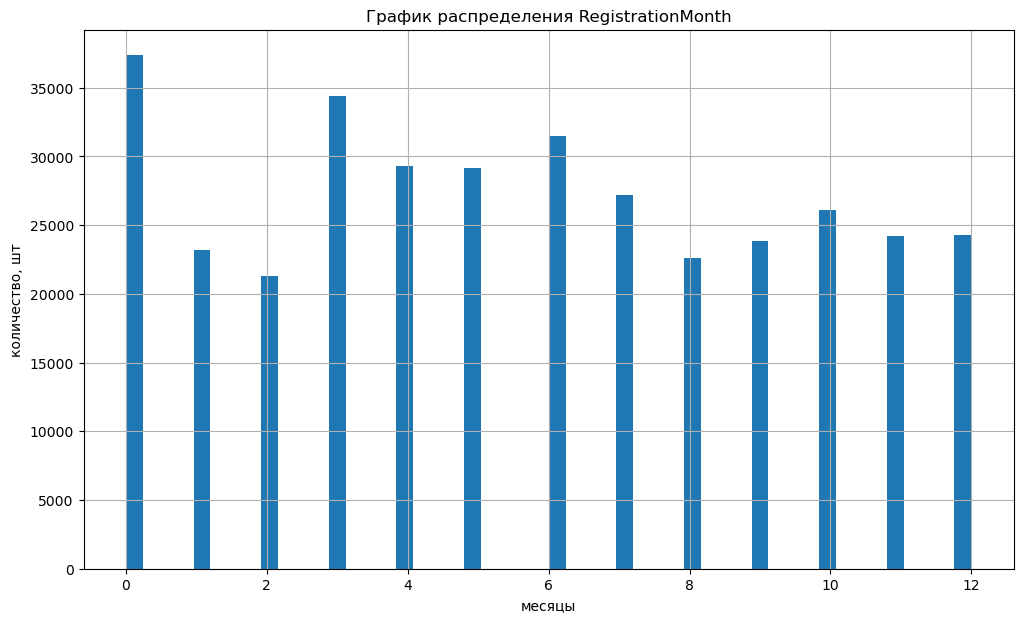

In [26]:
df_autos.RegistrationMonth.hist(bins=50,figsize=(12,7))
plt.title('График распределения RegistrationMonth')
plt.xlabel('месяцы')
plt.ylabel('количество, шт')
plt.show()

In [27]:
df_autos.query('RegistrationMonth==0')['RegistrationMonth'].count()

37352

Мы не можем избавиться от такого значительного объёма данных. Заменим `0` на `1`, чтобы считать тогда дату регистрации просто по году.

In [29]:
df_autos['RegistrationMonth'] = df_autos['RegistrationMonth'].replace(0, 1)

Теперь посмотрим на признак RegistrationYear. В нём явно присутствуют выбросы.

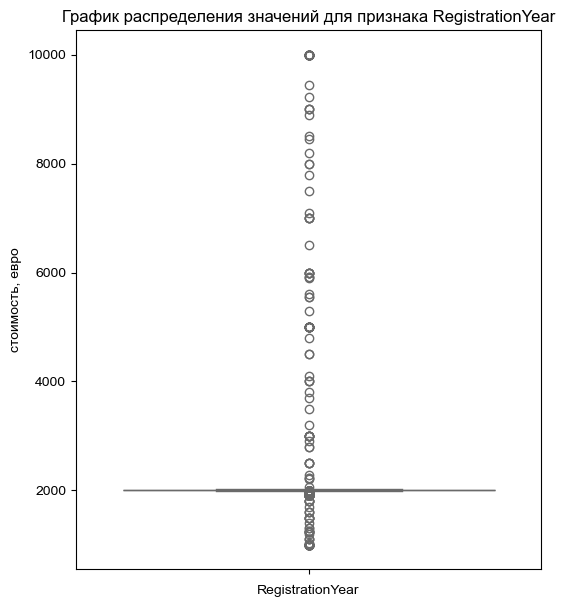

In [31]:
plt.figure(figsize=(6, 7))
sns.boxplot(data=df_autos['RegistrationYear'], palette="Set3")
sns.set_style("whitegrid")
plt.title("График распределения значений для признака RegistrationYear")
plt.xlabel("RegistrationYear")
plt.ylabel("стоимость, евро")
plt.show()

Посмотрим на первый перцентиль и отфильтруем данные по нему.

In [33]:
p1 = df_autos['RegistrationYear'].quantile(0.01)
df_filtered = df_autos[df_autos['RegistrationYear'] > p1].copy()

print(f"Пороговое значение 1-го перцентиля: {p1}")
print(f"Исходный размер данных: {len(df_autos)}")
print(f"Отфильтрованный размер: {len(df_filtered)}")
print(f"Удалено строк: {len(df_autos) - len(df_filtered)}")

Пороговое значение 1-го перцентиля: 1980.0
Исходный размер данных: 354369
Отфильтрованный размер: 350329
Удалено строк: 4040


In [34]:
df_autos = df_autos.query('1980 <= RegistrationYear <= 2016')

Посмотрим на данные после фильтрации.

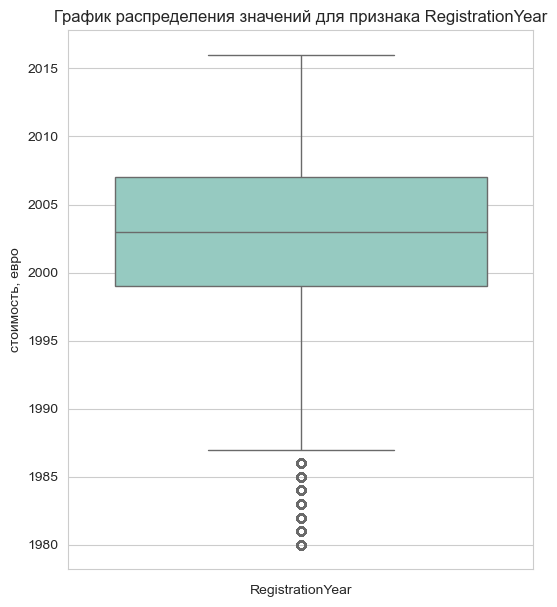

In [36]:
plt.figure(figsize=(6, 7))
sns.boxplot(data=df_autos['RegistrationYear'], palette="Set3")
sns.set_style("whitegrid")
plt.title("График распределения значений для признака RegistrationYear")
plt.xlabel("RegistrationYear")
plt.ylabel("стоимость, евро")
plt.show()

Теперь создадим признак `RegistrationDate`, который будет включать в себя признаки `RegistrationYear` и `RegistrationMonth`.

In [38]:
df_autos['RegistrationDate'] = pd.to_datetime(
    df_autos['RegistrationYear'].astype(str) + '-' + 
    df_autos['RegistrationMonth'].astype(str) + '-01')

Рассчитываем возраст в годах с точностью до месяца. Значение `365.25` поможет учитывать високосные годы. Столбец `RegistrationDate` можно в целом сразу удалить. Он нам не пригодится.

In [40]:
df_autos['CarAge'] = (
    (df_autos['DateCreated'] - df_autos['RegistrationDate']) 
    / pd.Timedelta(days=365.25)  # 365.25 учитывает високосные годы
).round(2)

df_autos.drop('RegistrationDate', axis=1, inplace=True)

Создаём теперь на основе `df_autos` новый датафрейм, с которым и будем работать `df_autos_filtered`.

In [42]:
df_autos_filtered = df_autos[['VehicleType', 'Gearbox', 'Power', 'Model',
                   'Kilometer', 'FuelType', 'Brand', 'Repaired', 'CarAge', 'Price']].copy()

In [43]:
df_review(df_autos_filtered)

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,CarAge,Price
0,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,23.23,480
1,coupe,manual,190,NaN,125000,gasoline,audi,yes,4.90,18300
2,suv,auto,163,grand,125000,gasoline,jeep,NaN,11.62,9800
3,small,manual,75,golf,150000,petrol,volkswagen,no,14.79,1500
4,small,manual,69,fabia,90000,gasoline,skoda,no,7.75,3600


<class 'pandas.core.frame.DataFrame'>
Index: 336387 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   VehicleType  313846 non-null  object 
 1   Gearbox      319177 non-null  object 
 2   Power        336387 non-null  int64  
 3   Model        319605 non-null  object 
 4   Kilometer    336387 non-null  int64  
 5   FuelType     309831 non-null  object 
 6   Brand        336387 non-null  object 
 7   Repaired     272680 non-null  object 
 8   CarAge       336387 non-null  float64
 9   Price        336387 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 28.2+ MB


,Power,Kilometer,CarAge,Price
count,336387.000000,336387.000000,336387.000000,336387.000000
mean,111.366973,128513.839714,12.984741,4447.274794
std,185.510237,37473.848050,6.106270,4526.680863
min,0.000000,5000.000000,-0.740000,0.000000
25%,70.000000,125000.000000,8.780000,1099.000000
50%,105.000000,150000.000000,13.030000,2750.000000
75%,143.000000,150000.000000,16.990000,6499.000000
max,20000.000000,150000.000000,36.260000,20000.000000


In [44]:
df_autos_filtered = df_autos_filtered.sort_values('CarAge', ascending=True)
df_autos_filtered

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,CarAge,Price
257002,NaN,manual,86,lanos,150000,petrol,daewoo,NaN,-0.74,400
16416,NaN,manual,60,polo,150000,petrol,volkswagen,NaN,-0.74,1000
139775,NaN,manual,0,passat,150000,NaN,volkswagen,no,-0.74,1000
180098,NaN,auto,170,mondeo,150000,NaN,ford,NaN,-0.74,800
167024,NaN,manual,140,golf,150000,gasoline,volkswagen,yes,-0.74,4499
...,...,...,...,...,...,...,...,...,...,...
292575,NaN,NaN,0,c_klasse,150000,NaN,mercedes_benz,NaN,36.26,15500
49875,NaN,manual,75,other,60000,petrol,volkswagen,NaN,36.26,5500
310601,NaN,NaN,0,other,150000,NaN,bmw,NaN,36.26,6400
269854,NaN,manual,22,500,90000,petrol,fiat,NaN,36.26,9350


## Предобработка данных

### Работа с пропущенными значениями

In [47]:
df_autos_filtered.isna().sum()

VehicleType    22541
Gearbox        17210
Power              0
Model          16782
Kilometer          0
FuelType       26556
Brand              0
Repaired       63707
CarAge             0
Price              0
dtype: int64

### VehicleType

Заполним пропуски `N/A`.

In [50]:
df_autos_filtered['VehicleType']=df_autos_filtered['VehicleType'].fillna('N/A')

### Model

Заполним пропуски `other`.

In [53]:
df_autos_filtered['Model']=df_autos_filtered['Model'].fillna('other')

### FuelType

Petrol и gasoline - это один и тот же тип топлива, замени его везде на gasoline.

In [56]:
df_autos_filtered.loc[df_autos_filtered['FuelType'] == 'petrol', 'FuelType'] = 'gasoline'

In [57]:
df_autos_filtered['FuelType'].isna().sum()

26556

In [58]:
df_autos_filtered.FuelType.value_counts()

FuelType
gasoline    303677
lpg           5137
cng            539
hybrid         223
other          167
electric        88
Name: count, dtype: int64

Заполним пропуски `other`.

In [60]:
df_autos_filtered['FuelType']=df_autos_filtered['FuelType'].fillna('other')

### Gearbox


Заполним пропуски `unknown`.

In [63]:
df_autos_filtered['Gearbox']=df_autos_filtered['Gearbox'].fillna('unknown')

### Repaired


Также заполним пропуски `unknown`.

In [66]:
df_autos_filtered['Repaired']=df_autos_filtered['Repaired'].fillna('unknown')

### Числовые значения

Построим гистограммы и боксплоты для числовых признаков датафрейма.

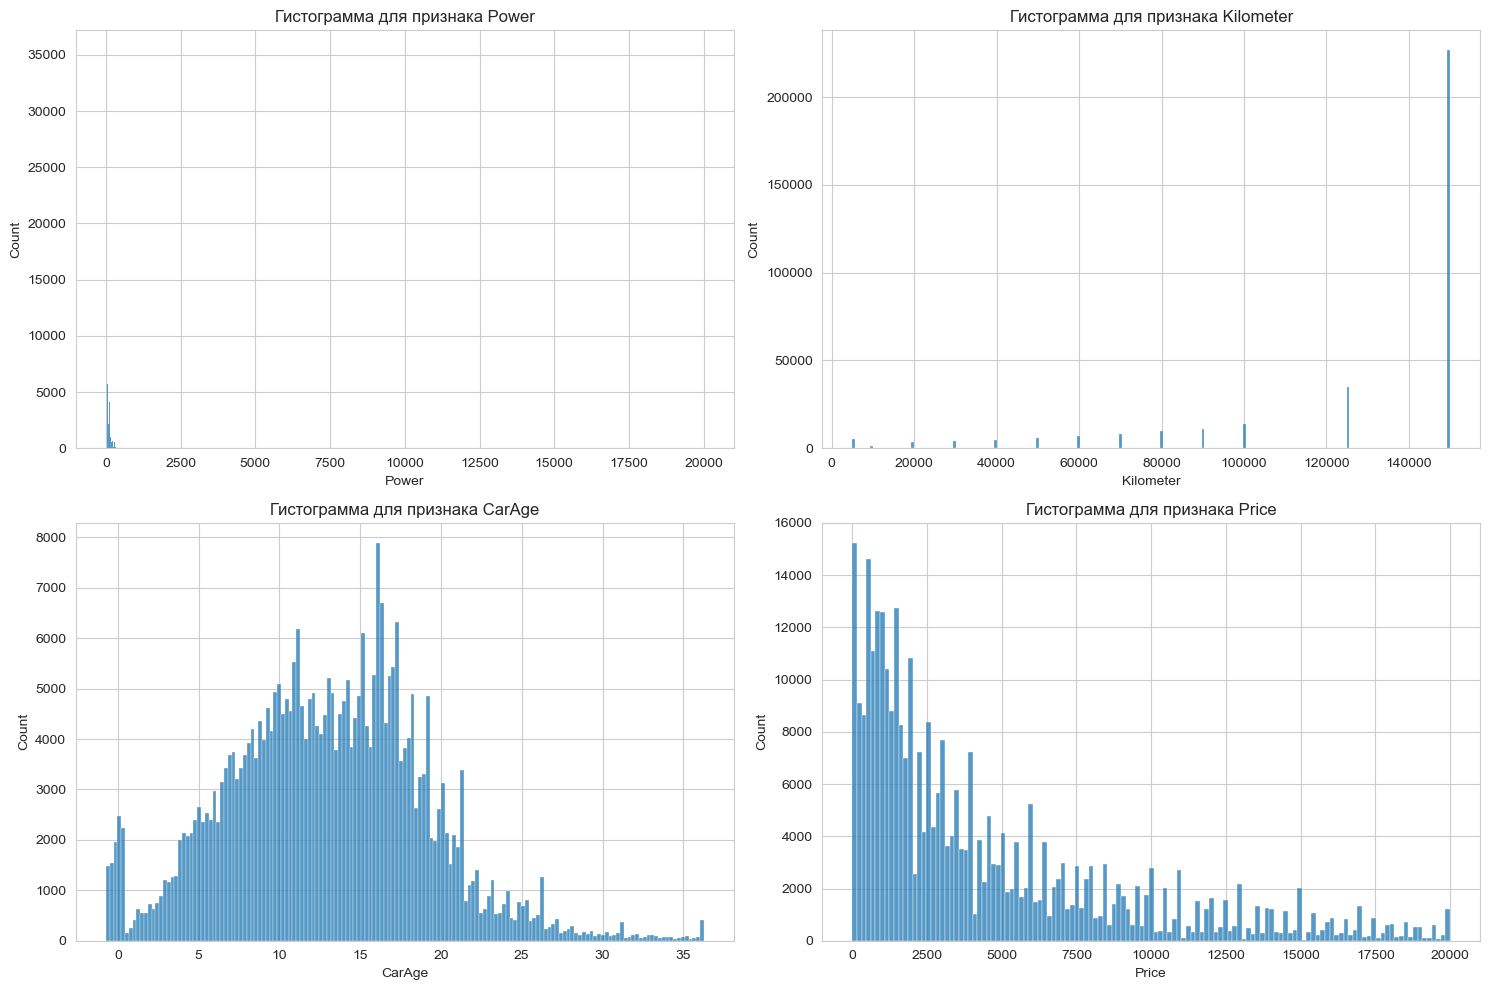

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
col_hist = ['Power', 'Kilometer', 'CarAge', 'Price']
for i, col in enumerate(col_hist):
    row = i // 2
    col_pos = i % 2
    sns.histplot(df_autos_filtered[col], ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Гистограмма для признака {col}')
    axes[row, col_pos].set_xlabel(col)  

plt.tight_layout()
plt.show()

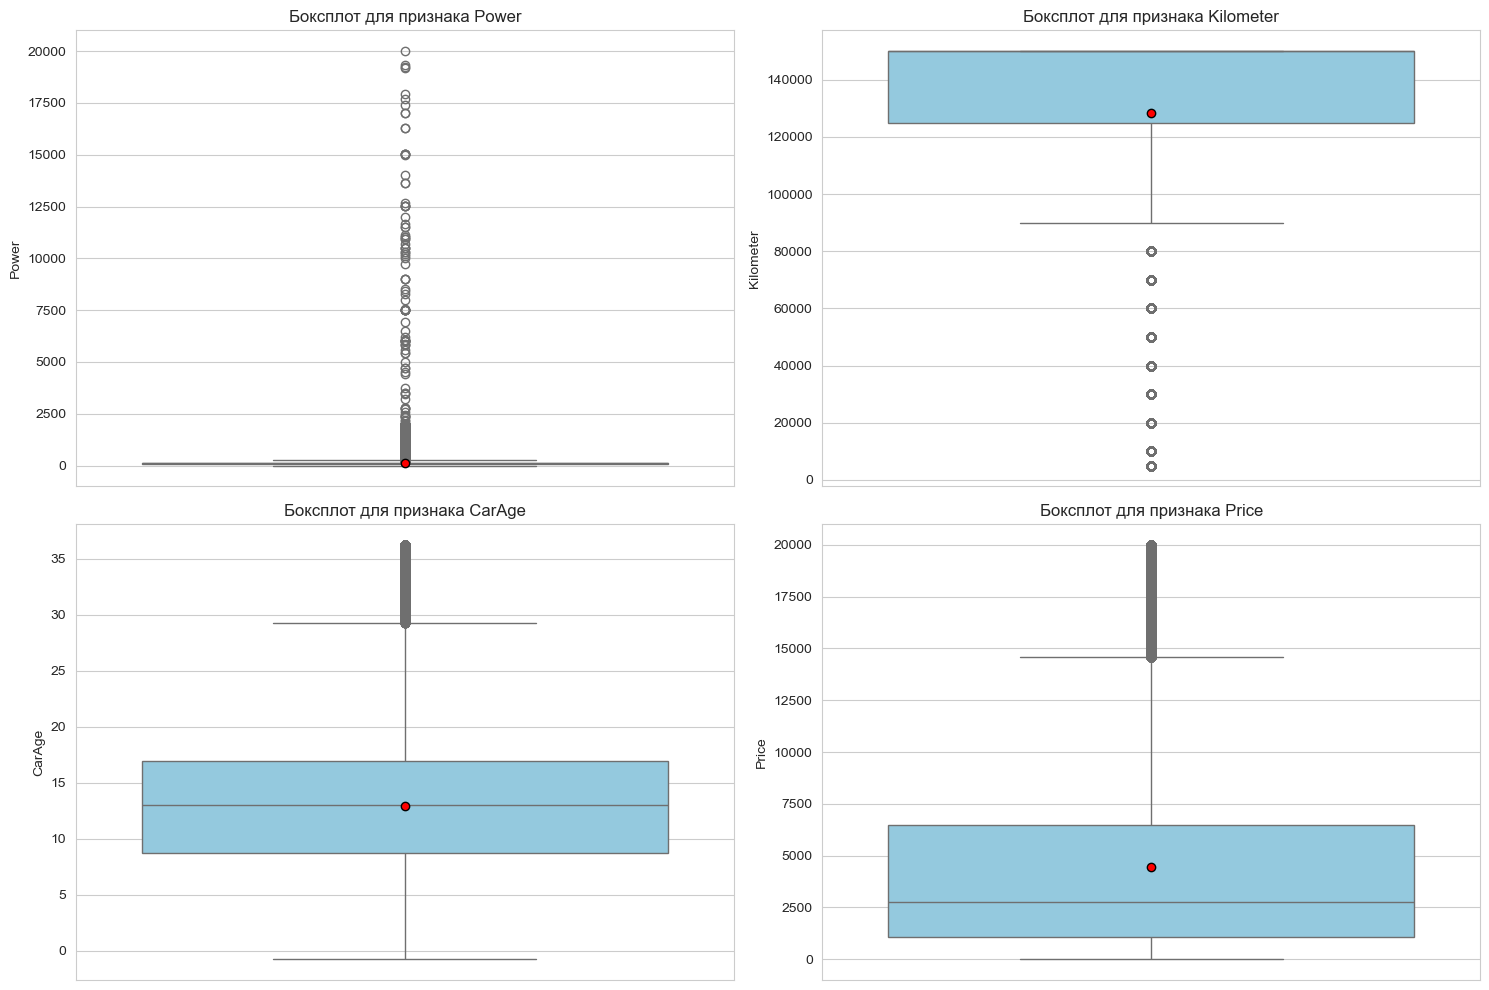

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

col_box = ['Power', 'Kilometer', 'CarAge', 'Price']

for i, col in enumerate(col_box):
    row = i // 2
    col_pos = i % 2
    
    sns.boxplot(data=df_autos_filtered, y=col, ax=axes[row, col_pos], 
                color='skyblue', showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black"})
    
    axes[row, col_pos].set_title(f'Боксплот для признака {col}')
    axes[row, col_pos].set_ylabel(col)  

plt.tight_layout()
plt.show()

### Power


Здесь наблюдаются явные выбросы. Поставим ограничения на минимальную мощность двигателя в 45 и на максимальную в 2028, так как согласно источникам, эти цифры являются самыми адекватными для нашей базы данных.

In [73]:
df_autos_filtered = df_autos_filtered.query('45 <= Power <= 500')

### CarAge

На графике видно, что у нас есть строки, в которых возраст автомобиля является отрицательным числом. Поставим ограничение на этот признак, чтобы число принимало только положительное значение.

In [76]:
df_autos_filtered = df_autos_filtered.query('CarAge>=0')

### Price

Вычислим 5-й перцентиль и поставим порог цены по нему.

In [79]:
df_autos_filtered.Price.quantile(0.05)

300.0

In [80]:
df_autos_filtered = df_autos_filtered.query('Price>=300')

### Kilometer


In [82]:
df_autos_filtered.Kilometer.sort_values().unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000])

Признак явно категориальный.

Добавим на основе признака `Kilometer` новый признак `MileageCat` со следующими значениями:

`low (5k–40k км):`
- машины после обкатки, почти без износа;
- цена обычно близка к новой.

`middle (50k–100k км):`
- оптимальный вариант для покупки (баланс цены и состояния).

`high (125k–150k км):`
- требуют проверки на серьезные поломки;
- цена в теории должна быть ниже.

In [85]:
bins = [0, 40_000, 100_000, np.inf]
labels = ['low', 'middle', 'high']
df_autos_filtered['MileageCat'] = pd.cut(
    df_autos_filtered['Kilometer'],
    bins=bins,
    labels=labels,
    right=False
)

print(df_autos_filtered['MileageCat'].value_counts())

MileageCat
high      228961
middle     42416
low         9858
Name: count, dtype: int64


### Работа с дубликатами

#### Явные дубликаты

In [88]:
print(f'Количество явных дубликатов: {df_autos_filtered.duplicated().sum()}')

Количество явных дубликатов: 13334


In [89]:
df_autos_filtered = df_autos_filtered.drop_duplicates()
print(f'Количество явных дубликатов после удаления: {df_autos_filtered.duplicated().sum()}')

Количество явных дубликатов после удаления: 0


#### Неявные дубликаты

In [91]:
for i in df_autos_filtered:
    if df_autos_filtered[i].dtype == 'object':
        print(i, ':')
        display(df_autos_filtered[i].unique())

VehicleType :


array(['N/A', 'wagon', 'sedan', 'small', 'coupe', 'suv', 'bus',
       'convertible', 'other'], dtype=object)

Gearbox :


array(['manual', 'auto', 'unknown'], dtype=object)

Model :


array(['twingo', 'a3', 'other', 'a6', 'megane', 'xc_reihe', '3_reihe',
       'golf', 'sharan', 'vectra', 'polo', 'a_klasse', 'corolla', 'ka',
       'punto', 'arosa', 'corsa', '3er', 'fortwo', 'micra', '5er',
       'scenic', 'i_reihe', '1_reihe', 'ducato', 'yaris', 'ibiza',
       'focus', 'cr_reihe', 'astra', 'agila', 'cooper', 'a4', 'vito',
       'alhambra', 'x_reihe', 'almera', 'passat', 'toledo', 'meriva',
       'omega', 'leon', 'transporter', 'fiesta', 'calibra', 'scirocco',
       'insignia', 'c_klasse', 'kaefer', 'civic', 'beetle', 'b_klasse',
       'a1', 'rio', 'clio', 'roadster', 'panda', 'caddy', 'transit',
       '900', '500', '147', 'v40', 'c1', 'galaxy', 'ceed', '1er', 'jetta',
       'swift', 'qashqai', 'a2', 'kangoo', 'clubman', 'fabia', 'mondeo',
       'impreza', 'kadett', 'modus', 'e_klasse', 'fusion', 'cuore', '7er',
       '6_reihe', 'carnival', 'lupo', 'combo', 'touran', '2_reihe',
       'ypsilon', 'bravo', 'c_reihe', 'espace', 'santa', 's_max', 'up',
       

FuelType :


array(['other', 'gasoline', 'lpg', 'electric', 'hybrid', 'cng'],
      dtype=object)

Brand :


array(['renault', 'audi', 'volvo', 'mazda', 'bmw', 'peugeot',
       'volkswagen', 'opel', 'mercedes_benz', 'toyota', 'ford', 'fiat',
       'seat', 'smart', 'nissan', 'suzuki', 'hyundai', 'daewoo', 'honda',
       'mini', 'citroen', 'mitsubishi', 'skoda', 'kia', 'saab',
       'alfa_romeo', 'subaru', 'daihatsu', 'lancia', 'rover', 'dacia',
       'jeep', 'chrysler', 'sonstige_autos', 'land_rover', 'chevrolet',
       'lada', 'porsche', 'jaguar', 'trabant'], dtype=object)

Repaired :


array(['unknown', 'no', 'yes'], dtype=object)

Посмотрим на числовые признаки после обработки.

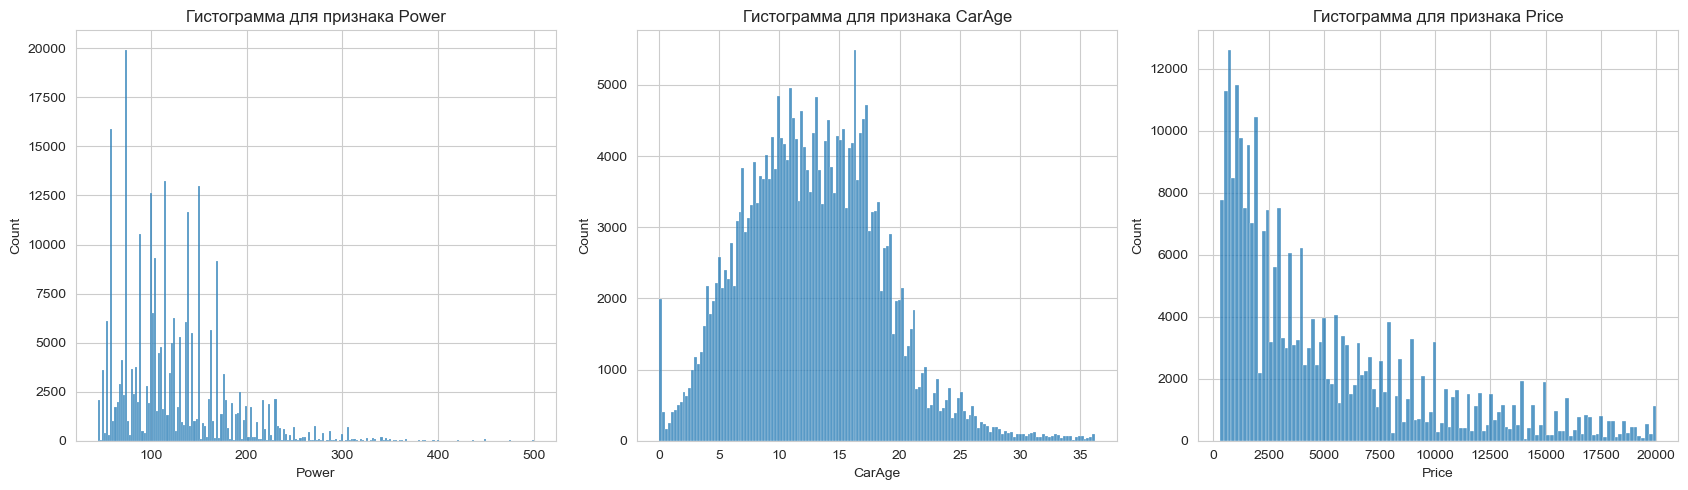

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

col_hist = ['Power', 'CarAge', 'Price']

for i, col in enumerate(col_hist):
    sns.histplot(df_autos_filtered[col], ax=axes[i])  
    axes[i].set_title(f'Гистограмма для признака {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

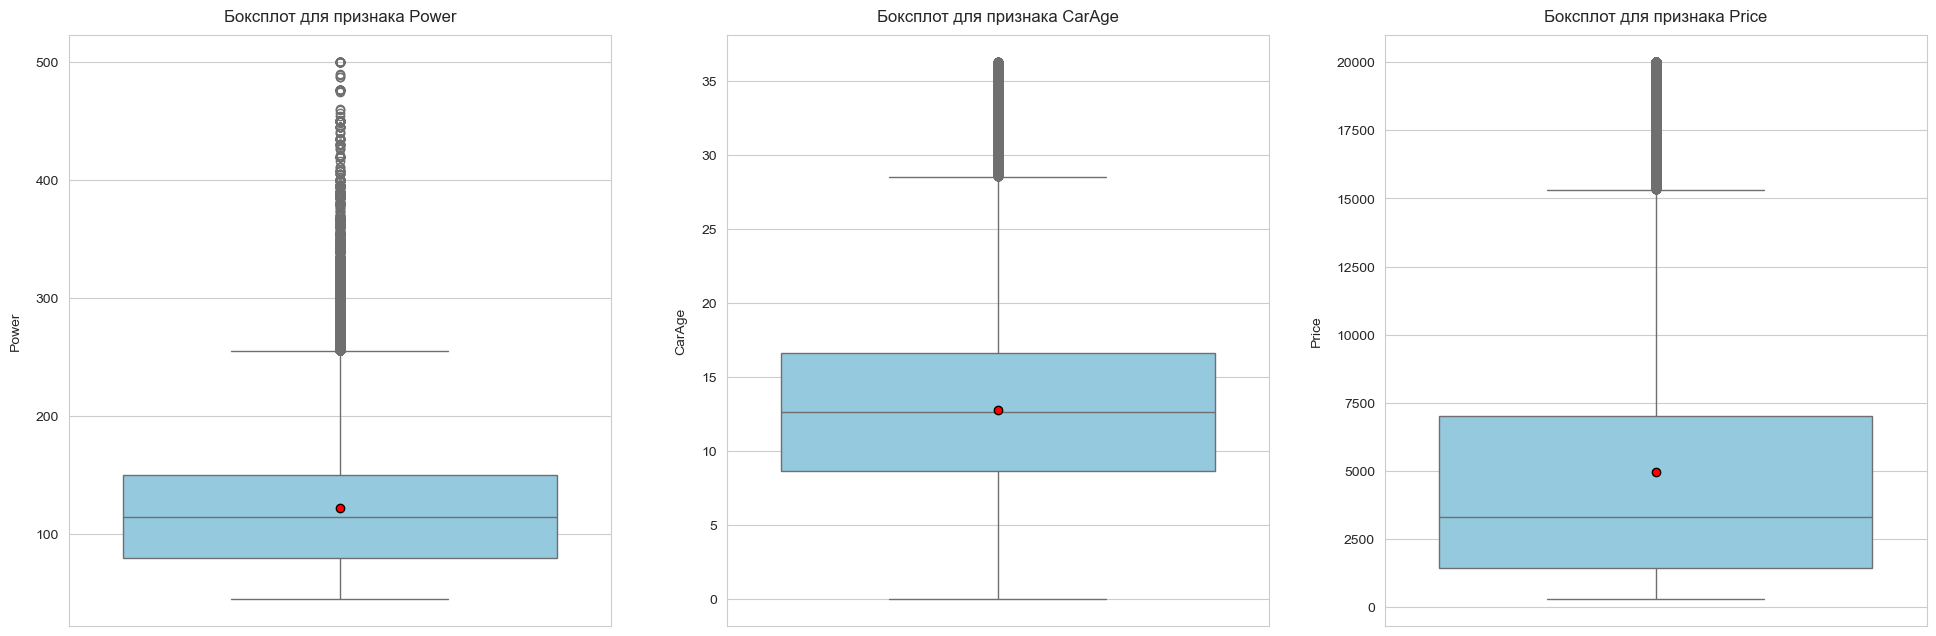

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

col_box = ['Power', 'CarAge', 'Price']

for i, col in enumerate(col_box):
    sns.boxplot(
        data=df_autos_filtered, 
        y=col, 
        ax=axes[i],
        color='skyblue', 
        showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"}
    )
    axes[i].set_title(f'Боксплот для признака {col}', pad=10)
    axes[i].set_ylabel(col, labelpad=10)

plt.tight_layout(pad=3.0)
plt.show()

In [95]:
df_review(df_autos_filtered)

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,CarAge,Price,MileageCat
12343,N/A,manual,58,twingo,150000,other,renault,unknown,0.0,400,high
97056,wagon,manual,110,a3,5000,gasoline,audi,no,0.0,19800,low
283341,sedan,auto,114,other,5000,gasoline,renault,no,0.0,16200,low
116440,N/A,auto,163,a6,150000,other,audi,yes,0.0,1350,high
233088,N/A,manual,125,a3,150000,gasoline,audi,no,-0.0,900,high


<class 'pandas.core.frame.DataFrame'>
Index: 267901 entries, 12343 to 49875
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   VehicleType  267901 non-null  object  
 1   Gearbox      267901 non-null  object  
 2   Power        267901 non-null  int64   
 3   Model        267901 non-null  object  
 4   Kilometer    267901 non-null  int64   
 5   FuelType     267901 non-null  object  
 6   Brand        267901 non-null  object  
 7   Repaired     267901 non-null  object  
 8   CarAge       267901 non-null  float64 
 9   Price        267901 non-null  int64   
 10  MileageCat   267901 non-null  category
dtypes: category(1), float64(1), int64(3), object(6)
memory usage: 22.7+ MB


,Power,Kilometer,CarAge,Price
count,267901.000000,267901.000000,267901.000000,267901.000000
mean,122.379767,128492.764118,12.773160,4976.904916
std,52.984661,36415.502383,5.708738,4603.559406
min,45.000000,5000.000000,0.000000,300.000000
25%,80.000000,125000.000000,8.660000,1450.000000
50%,115.000000,150000.000000,12.610000,3300.000000
75%,150.000000,150000.000000,16.610000,7000.000000
max,500.000000,150000.000000,36.260000,20000.000000


## Обучение моделей

In [97]:
interval_cols = ['Power', 'CarAge', 'Price']

In [98]:
phik_correlation = df_autos_filtered.phik_matrix(interval_cols=interval_cols)
phik_correlation

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,CarAge,Price,MileageCat
VehicleType,1.000000,0.383637,0.477058,0.902633,0.199063,0.248411,0.594370,0.299837,0.260249,0.259438,0.287287
Gearbox,0.383637,1.000000,0.469228,0.624905,0.050467,0.215244,0.519205,0.247985,0.121697,0.286204,0.070402
Power,0.477058,0.469228,1.000000,0.770362,0.113339,0.090154,0.561293,0.083282,0.257868,0.505411,0.126390
Model,0.902633,0.624905,0.770362,1.000000,0.440053,0.335320,0.997796,0.211648,0.614637,0.568275,0.501395
Kilometer,0.199063,0.050467,0.113339,0.440053,1.000000,0.086805,0.266505,0.177698,0.485195,0.329420,1.000000
FuelType,0.248411,0.215244,0.090154,0.335320,0.086805,1.000000,0.197829,0.271827,0.104509,0.099466,0.120694
Brand,0.594370,0.519205,0.561293,0.997796,0.266505,0.197829,1.000000,0.110510,0.325428,0.352058,0.317296
Repaired,0.299837,0.247985,0.083282,0.211648,0.177698,0.271827,0.110510,1.000000,0.216715,0.309733,0.235209
CarAge,0.260249,0.121697,0.257868,0.614637,0.485195,0.104509,0.325428,0.216715,1.000000,0.688742,0.568356
Price,0.259438,0.286204,0.505411,0.568275,0.329420,0.099466,0.352058,0.309733,0.688742,1.000000,0.397285


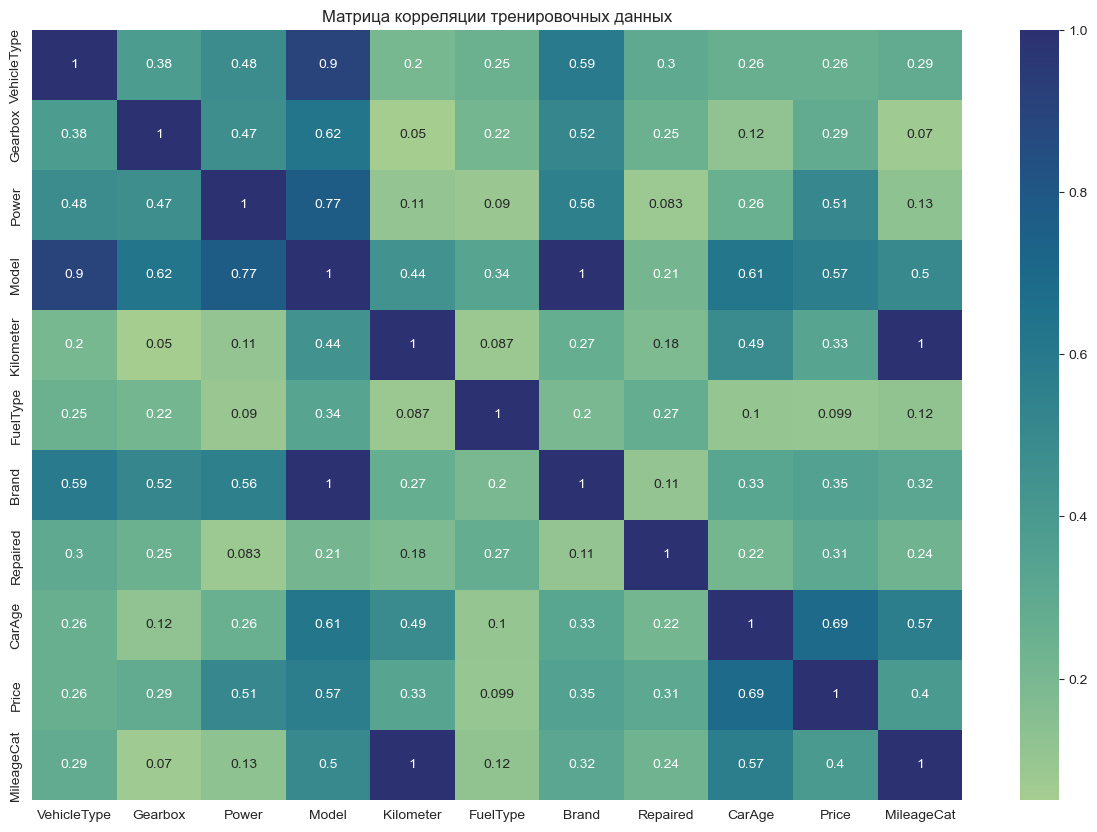

In [99]:
plt.figure(figsize=(15, 10))
sns.heatmap(phik_correlation, annot=True, cmap='crest')
plt.title('Матрица корреляции тренировочных данных');

Т.к. коэффициент корреляции между указанными признаками не превышает 0.8, все входные признаки будут использованы для обучения модели.

In [101]:
columns = ['VehicleType', 'Gearbox', 'Power', 'Model', 'FuelType', 'Brand',
           'Repaired', 'CarAge', 'MileageCat', 'Price']
df_model = df_autos_filtered[columns].copy()
df_model.head(5)

,VehicleType,Gearbox,Power,Model,FuelType,Brand,Repaired,CarAge,MileageCat,Price
12343,N/A,manual,58,twingo,other,renault,unknown,0.0,high,400
97056,wagon,manual,110,a3,gasoline,audi,no,0.0,low,19800
283341,sedan,auto,114,other,gasoline,renault,no,0.0,low,16200
116440,N/A,auto,163,a6,other,audi,yes,0.0,high,1350
233088,N/A,manual,125,a3,gasoline,audi,no,-0.0,high,900


In [102]:
df_model=df_model.reset_index(drop=True)

In [103]:
X = df_model.drop(['Price'], axis=1)
y = df_model['Price']

In [104]:
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'MileageCat']
num_cols = ['Power', 'CarAge']

In [105]:
num_transformer = Pipeline([
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

In [106]:
TEST_SIZE = 0.25
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

Создадим пайплайны для обучения моделей. Будем обучать LigtGBM, RandomForest и LinearRegression.

In [108]:
lgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1)),
])

lgb_param_dist = {
    "model__n_estimators": [100, 150, 200, 250],
    "model__learning_rate": uniform(0.03, 0.05),
    "model__num_leaves": [20, 31, 40, 50, 63],
    "model__max_depth": [4, 6, 8],
}

In [109]:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1, bootstrap=True)),
])

rf_param_dist = {
    "model__n_estimators": [100, 150, 200, 250],
    "model__max_depth": [5, 10, 15],
    "model__min_samples_split": [2, 3, 4],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", "log2", 0.3],
}

In [110]:
linear_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression()),
])

linear_param_dist = {
    "model__fit_intercept": [True, False],
    "model__positive": [True, False],
}

In [111]:
bench = []

lgb_s, lgb_t = run_search("LightGBM", lgb_pipeline, lgb_param_dist)
lgb_pred, lgb_pt = timed_pred(lgb_s.best_estimator_)
bench.append(evaluate("LightGBM", lgb_pred, lgb_t, lgb_pt))

rf_s, rf_t = run_search("RandomForest", rf_pipeline, rf_param_dist)
rf_pred, rf_pt = timed_pred(rf_s.best_estimator_)
bench.append(evaluate("RandomForest", rf_pred, rf_t, rf_pt))

lin_s, lin_t = run_search("LinearRegression", linear_pipeline, linear_param_dist)
lin_pred, lin_pt = timed_pred(lin_s.best_estimator_)
bench.append(evaluate("LinearRegression", lin_pred, lin_t, lin_pt))

In [112]:
res = pd.DataFrame(bench).sort_values(["Pass", "RMSE"], ascending=[False, True]).reset_index(drop=True)
print(res)

              Model         RMSE  TrainTime_s  PredictTime_ms  Pass
0          LightGBM  1629.586788    30.231811      119.918917  True
1      RandomForest  1646.840129   199.524323      152.872250  True
2  LinearRegression  2431.943954     2.963658       39.920750  True


In [119]:
best_rmse = res.loc[0, "RMSE"]
if best_rmse >= 2500:
    raise ValueError(f"Ни одна модель не прошла порог RMSE < {2500}. Лучший показатель = {best_rmse:.2f}")
else:
    print(f"Лучший показатель RMSE = {best_rmse:.2f} (< {2500})")

Лучший показатель RMSE = 1629.59 (< 2500)


In [117]:
selected_name = res.loc[0, "Model"]
selected_est = {
    "LightGBM": lgb_s.best_estimator_,
    "RandomForest": rf_s.best_estimator_,
    "LinearRegression": lin_s.best_estimator_,
}[selected_name]

y_pred_final = selected_est.predict(X_test)
rmse_final = mean_squared_error(y_test, y_pred_final, squared=False)
mae_final = mean_squared_error(y_test, y_pred_final, squared=False)
from sklearn.metrics import mean_absolute_error, r2_score
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("Финальная оценка модели на тестовой выборке")
print(f"Название выбранной модели: {selected_name}")
print(f"RMSE: {rmse_final:.2f}")
print(f"MAE : {mae_final:.2f}")
print(f"R²  : {r2_final:.3f}")

Финальная оценка модели на тестовой выборке
Название выбранной модели: LightGBM
RMSE: 1629.59
MAE : 1063.62
R²  : 0.873


**Вывод:**     
Лучшую точность среди всех трёх кандидатов (RMSE и MAE минимальны) показала модель LightGBM.